<a href="https://colab.research.google.com/github/bdunn20/book_code/blob/main/football_analytics/Ch_5_Generalized_Linear_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 5: Generlizaed Linear Models: Completion Percentage over Expected

### Packages

In [ ]:
! pip install nfl_data_py

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.5 MB/s eta 0:00:00
  Created wheel for nfl_data_py: filename=nfl_data_py-0.3.1-py3-none-any.whl size=13187 sha256=f62c7b1ca23119bc10c8b6c3b1e81fb3c74b242fca1a240ca02fc48784cf0774
  Stored in directory: /root/.cache/pip/wheels/ca/2e/d2/4def312ac7c070e1c0002e91ecc6923481a86c3ebd5b2c5413
Successfully built nfl_data_py


In [ ]:
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

### Import Data

In [ ]:
seasons = range(2016, 2023 + 1)
pbp_py = nfl.import_pbp_data(seasons)

pbp_py_pass = pbp_py.query('play_type == "pass" & passer_id.notnull() &' + 'air_yards.notnull()').reset_index()

2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


### Plot Air Yards vs Completion %


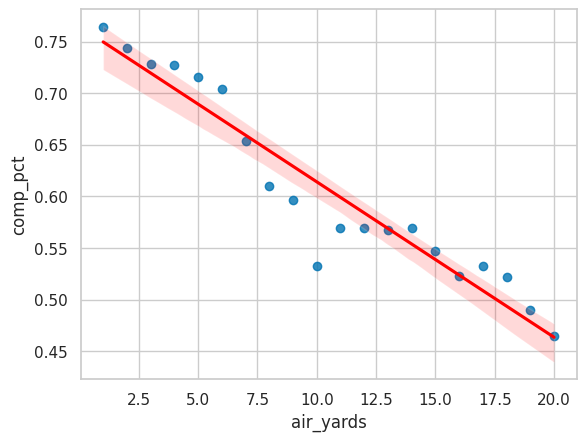

In [ ]:
# set theme
sns.set_theme(style="whitegrid", palette="colorblind")

pass_pct_py = pbp_py_pass.query('0 < air_yards <= 20').groupby('air_yards').agg({"complete_pass": ["mean"]})

pass_pct_py.columns = list(map('_'.join, pass_pct_py.columns))

pass_pct_py.reset_index(inplace=True)

pass_pct_py.rename(columns={'complete_pass_mean': 'comp_pct'}, inplace=True)

sns.regplot(data=pass_pct_py, x='air_yards', y='comp_pct', line_kws={'color': 'red'})

plt.show()

### Building a Generalized Linear Model
Specifically, a logistic regression.

In [ ]:
complete_ay_py = smf.glm(formula='complete_pass ~ air_yards', data=pbp_py_pass,
                         family=sm.families.Binomial()).fit()

complete_ay_py.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          complete_pass   No. Observations:               146676
Model:                            GLM   Df Residuals:                   146674
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -90285.
Date:                Mon, 18 Dec 2023   Deviance:                   1.8057e+05
Time:                        18:03:55   Pearson chi2:                 1.47e+05
No. Iterations:                     5   Pseudo R-squ. (CS):            0.07055
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0731      0.008    141.092      0.000       1.058       1.088
air_yards     -0.0574      0.001    -97.205      0.000      -0.059      -0.056
==============================================================================
"""

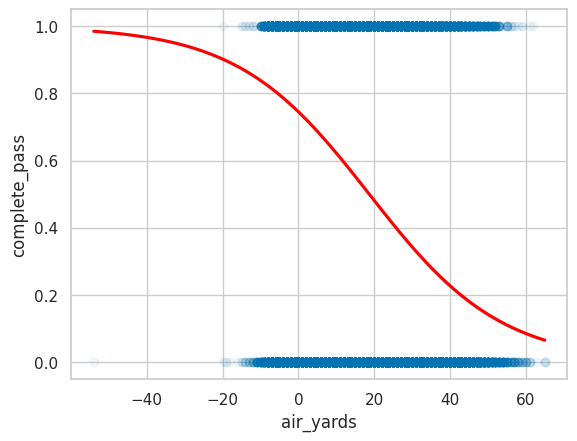

In [ ]:
# plot the above results
sns.regplot(data=pbp_py_pass, x='air_yards', y='complete_pass', logistic=True,
            line_kws={'color': 'red'}, scatter_kws={'alpha':0.05})

plt.show()

In the above plot, the curved line is the logistic function. The semi-transparent points are the binary outcome for completed pass. Because of the large number of overlapping points, the logistic line is necessary to see any trends in the data.

With a linear model, the CPOE would simply be the residual b/c only one type exists. Different types of residuals exist for GLMs, so here we will calculate manually (rather than extracting from the fit) to ensure we know which type of residual we are using.

In [ ]:
# use predict() to extract the predicted value from the model above
pbp_py_pass["exp_completion"] = complete_ay_py.predict()

pbp_py_pass["cpoe"] = pbp_py_pass["complete_pass"] - pbp_py_pass["exp_completion"]

In [ ]:
# look at leaders in CPOE since 2016 vs leaders in actual comp %
# only looking at passes that have non-NA air_yards
# include only QB with > 100 attempts
cpoe_py = pbp_py_pass.groupby(["season", "passer_id", "passer"]).agg({"cpoe": ["count", "mean"], "complete_pass":["mean"]})

cpoe_py.columns = list(map('_'.join, cpoe_py.columns))
cpoe_py.reset_index(inplace=True)

cpoe_py = cpoe_py.rename(columns={"cpoe_count": "n", "cpoe_mean": "cpoe", "complete_pass_mean": "compl"}).query("n > 100")

print(cpoe_py.sort_values("cpoe", ascending=False))

     season   passer_id               passer    n      cpoe     compl
299    2019  00-0020531              D.Brees  406  0.093943  0.756158
193    2018  00-0020531              D.Brees  566  0.086329  0.738516
788    2023  00-0035100           J.Browning  144  0.076057  0.736111
467    2020  00-0033537             D.Watson  542  0.073321  0.704797
465    2020  00-0033357               T.Hill  121  0.072357  0.727273
..      ...         ...                  ...  ...       ...       ...
112    2017  00-0025430            D.Stanton  159 -0.110341  0.496855
730    2022  00-0037327           S.Thompson  150 -0.116949  0.520000
826    2023  00-0038583  D.Thompson-Robinson  108 -0.120949  0.546296
766    2023  00-0033275             P.Walker  110 -0.147725  0.490909
163    2017  00-0031568              B.Petty  112 -0.151996  0.491071

[343 rows x 6 columns]


### Adding additional features to the model
Specifically:
- down (down)
- distance to first down (ydstogo)
- distance to end zone (yardline_100)
- pass location (pass_location)
- QB hit (qb_hit)

In [ ]:
# change the variables to factors
# remove missing data & format the data
pbp_py_pass['down'] = pbp_py_pass['down'].astype(str)
pbp_py_pass['qb_hit'] = pbp_py_pass['qb_hit'].astype(str)

# select the columns to be used
# drop the NA values
pbp_py_pass_no_miss = pbp_py_pass[["passer", "passer_id", "season", "down", "qb_hit", "complete_pass", "ydstogo",
                                   "yardline_100", "air_yards", "pass_location"]].dropna(axis = 0)

# build and fit the model
complete_more_py = smf.glm(formula = 'complete_pass ~ down * ydstogo + yardline_100 + air_yards + pass_location + qb_hit',
                           data = pbp_py_pass_no_miss, family=sm.families.Binomial()).fit()

# extract the outputs and calculate the CPOE
pbp_py_pass_no_miss["exp_completion"] = complete_more_py.predict()

pbp_py_pass_no_miss["cpoe"] = pbp_py_pass_no_miss["complete_pass"] - pbp_py_pass_no_miss["exp_completion"]

# summarize the outputse and reformat and rename the columns
cpoe_py_more = pbp_py_pass_no_miss.groupby(["season", "passer_id", "passer"]).agg({"cpoe": ["count", "mean"], "complete_pass": ["mean"], "exp_completion": ["mean"]})

cpoe_py_more.columns = list(map('_'.join, cpoe_py_more.columns))
cpoe_py_more.reset_index(inplace=True)

cpoe_py_more = cpoe_py_more.rename(columns = {"cpoe_count": "n", "cpoe_mean": "cpoe", "complete_pass_mean": "compl", "exp_completion_mean": "exp_completion"}).query("n > 100")

In [ ]:
print(cpoe_py_more.sort_values("cpoe", ascending=False))

     season   passer_id               passer    n      cpoe     compl  \
193    2018  00-0020531              D.Brees  566  0.088433  0.738516   
299    2019  00-0020531              D.Brees  406  0.087544  0.756158   
465    2020  00-0033357               T.Hill  121  0.082642  0.727273   
22     2016  00-0026143               M.Ryan  631  0.077364  0.702060   
788    2023  00-0035100           J.Browning  144  0.072530  0.736111   
..      ...         ...                  ...  ...       ...       ...   
91     2016  00-0033106               J.Goff  204 -0.112562  0.549020   
526    2021  00-0027939             C.Newton  126 -0.123394  0.547619   
826    2023  00-0038583  D.Thompson-Robinson  108 -0.125581  0.546296   
766    2023  00-0033275             P.Walker  110 -0.125838  0.490909   
163    2017  00-0031568              B.Petty  112 -0.166892  0.491071   

     exp_completion  
193        0.650082  
299        0.668614  
465        0.644631  
22         0.624696  
788        0.

In [ ]:
cpoe_py_more.query('passer == "B.Purdy"')

,season,passer_id,passer,n,cpoe,compl,exp_completion
733,2022,00-0037834,B.Purdy,233,0.016585,0.665236,0.648651
816,2023,00-0037834,B.Purdy,381,0.066768,0.703412,0.636644


In [ ]:
cpoe_py_more.query('passer == "A.Rodgers"')

,season,passer_id,passer,n,cpoe,compl,exp_completion
12,2016,00-0023459,A.Rodgers,736,0.023267,0.653533,0.630266
104,2017,00-0023459,A.Rodgers,237,-0.008545,0.649789,0.658334
201,2018,00-0023459,A.Rodgers,595,-0.012622,0.625210,0.637832
306,2019,00-0023459,A.Rodgers,634,-0.003659,0.630915,0.634573
407,2020,00-0023459,A.Rodgers,607,0.060715,0.705107,0.644392
515,2021,00-0023459,A.Rodgers,556,0.054374,0.694245,0.639871
634,2022,00-0023459,A.Rodgers,540,0.002938,0.648148,0.645210


In [ ]:
cpoe_py_more.query('passer == "T.Brady"')

,season,passer_id,passer,n,cpoe,compl,exp_completion
0,2016,00-0019596,T.Brady,572,0.028658,0.671329,0.642670
95,2017,00-0019596,T.Brady,718,0.027498,0.660167,0.632669
192,2018,00-0019596,T.Brady,693,0.012825,0.663781,0.650956
298,2019,00-0019596,T.Brady,650,-0.039020,0.604615,0.643636
401,2020,00-0019596,T.Brady,742,0.024864,0.649596,0.624732
513,2021,00-0019596,T.Brady,808,0.021629,0.673267,0.651638
632,2022,00-0019596,T.Brady,796,-0.004374,0.659548,0.663921


In [ ]:
cpoe_py_more.query('passer == "P.Mahomes"')

,season,passer_id,passer,n,cpoe,compl,exp_completion
279,2018,00-0033873,P.Mahomes,651,0.039485,0.654378,0.614892
372,2019,00-0033873,P.Mahomes,596,0.021072,0.656040,0.634968
471,2020,00-0033873,P.Mahomes,703,0.025223,0.662873,0.637651
577,2021,00-0033873,P.Mahomes,779,0.020751,0.673941,0.653190
681,2022,00-0033873,P.Mahomes,748,0.030959,0.677808,0.646848
773,2023,00-0033873,P.Mahomes,522,0.027119,0.676245,0.649126


### Is CPOE more stable than completion %?

In [ ]:
# calc lag between current season and prior season CPOE
cols_keep = ["season", "passer_id", "passer", "cpoe", "compl", "exp_completion"]

# create current df
cpoe_now_py = cpoe_py_more[cols_keep].copy()

# create last year df
cpoe_last_py = cpoe_now_py[cols_keep].copy()

# rename columns
cpoe_last_py.rename(columns = {'cpoe': 'cpoe_last', 'compl': 'compl_last', 'exp_completion': 'exp_completion_last'}, inplace=True)

# add 1 to season
cpoe_last_py["season"] += 1

# merge together current & last df
cpoe_lag_py = cpoe_now_py.merge(cpoe_last_py, how='inner', on=['passer_id', 'passer', 'season'])

In [ ]:
# examine the correlation for pass completion
cpoe_lag_py[['compl_last', 'compl']].corr()

,compl_last,compl
compl_last,1.000000,0.453727
compl,0.453727,1.000000


In [ ]:
# examine the correlation for cpoe
cpoe_lag_py[['cpoe_last', 'cpoe']].corr()

,cpoe_last,cpoe
cpoe_last,1.000000,0.474839
cpoe,0.474839,1.000000


In [ ]:
# examine the correlation of expected completion
cpoe_lag_py[['exp_completion', 'exp_completion_last']].corr()

,exp_completion,exp_completion_last
exp_completion,1.000000,0.449688
exp_completion_last,0.449688,1.000000
